In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import requests

# Blood Cells Feature Extraction
Given an image with a blood smear can we extract the separate cells?

## Abstract
TODO: Describe the problem, procedures, and outcomes in short. Do this section last.
The count of blood cells is a widely used test to detect abnormalities and to diagnose different diseases.

## Introduction

The main task of this notebook is trying to extract blood cells from a dataset with blood smears including various types of cells with different types, coloring, shapes, etc. The main dataset that we will use is https://mahmudulalam.github.io/Complete-Blood-Cell-Count-Dataset/. It contains 360 blood smear images. Actually, the dataset includes annotations for the images but for now, we will try to segment and detect them using image processing techniques using OpenCV library.

### Short description of blood smears

<img src="https://askhematologist.com/wp-content/uploads/2016/02/blood-cells-300x214.jpg">

Major types of blood cells include:

| Major Cell Type| Main Function | Diameter | Specific characteristics|
| --- | --- | --- | --- |
| Red blood cells (erythrocytes) | carry oxygen | 6 - 8 μm. | oval biconcave disks (i.e. disc-shaped with a pale-staining central area) without a cell nucleus and most organelles|
| White blood cells (leukocytes) | immune system | 12 - 17 µm | have a clear nucleus; different types: neutrophils, eosinophils, basophils, lymphocytes, and monocytes |
| Platelets (thrombocytes) | initiate a blood clot | 2 – 3 µm in greatest diameter | very small, no nucleus |

Whole blood contains red cells, white cells, and platelets (45% of volume) suspended in blood plasma (55% of volume).


Now, let's try to look at a sample image from the dataset. But first, let's define a few help functions for reading an image from an url and plotting an image.

In [3]:
def read_image_by_url(url):
    """
    read an image by a given url containing an image
    """
    response = requests.get(url, stream = True).raw
    image = np.asarray(bytearray(response.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def plot_image(
    image, 
    title, 
    colour_map = "gray",
    show_figure = True,
    plot_axis = None):
    """
    shows an OPENCV image in BGR format with a given title
    @colour_map - it can be "gray" or "color"
    """
    
    ax = plot_axis
    if plot_axis == None:
        _, ax = plt.subplots()
        
    if colour_map == "color":
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
    elif colour_map == "gray":
        ax.imshow(image, cmap = colour_map)
    else:
        raise ValueError("The colour map must be either \"color\" or \"gray\"")
        
    ax.set_title(title)
    ax.axis("off")
    if show_figure:
        plt.show()    

In [4]:
URL = "https://raw.githubusercontent.com/MahmudulAlam/Complete-Blood-Cell-Count-Dataset/master/Testing/Images/"

Let's look at a few sample images:

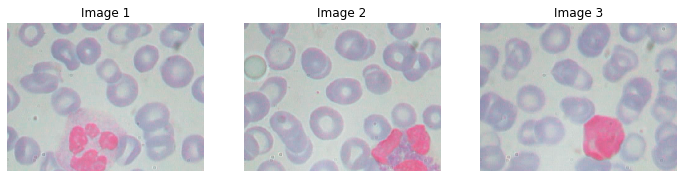

In [5]:
image1 = read_image_by_url(URL + "BloodImage_00346.jpg")
image2 = read_image_by_url(URL + "BloodImage_00345.jpg")
image3 = read_image_by_url(URL + "BloodImage_00347.jpg")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
plot_image(image1, "Image 1", plot_axis = ax1, show_figure = False)
plot_image(image2, "Image 2", plot_axis = ax2, show_figure = False)
plot_image(image3, "Image 3", plot_axis = ax3, show_figure = False)
plt.show()

## Segmentation

### Preprocessing
Usually the input images are not always clear enough and they need some initial preprocessing in order to improve contrast, eliminate noise if possible and generally improve the quality of the image. Also, it is a good idea to have some "standard" initial conditions for all processed images in order to produce more accurate results with the further processing.

Here are the two main preprocessing techniques we will try:
- Histogram Equalization
- Filtering

In [6]:
def plot_image_colors_histogram(
    image,
    show_figure = True, 
    plot_axis = None):
    
    ax = plot_axis
    if plot_axis == None:
        _, ax = plt.subplots()
    
    ax.hist(image.flatten(), 256, [0, 256], color = 'g')
    ax.set_xlim([0, 256])
    ax.set_title("Colors distribution")   
    ax.set_xlabel("Color intensity levels [0, 255]")
    ax.set_ylabel("Number of pixels")
    
    if show_figure:
        plt.show()

#### Histogram Equalization
In the provided dataset, images have more specific range of values i.e. the images are a little bit more brighter and most of their pixels have high values. We will try to have values from the whole grayscale spectrum. The idea is to improve the contrast of the image.
Let's take a look:

In [7]:
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

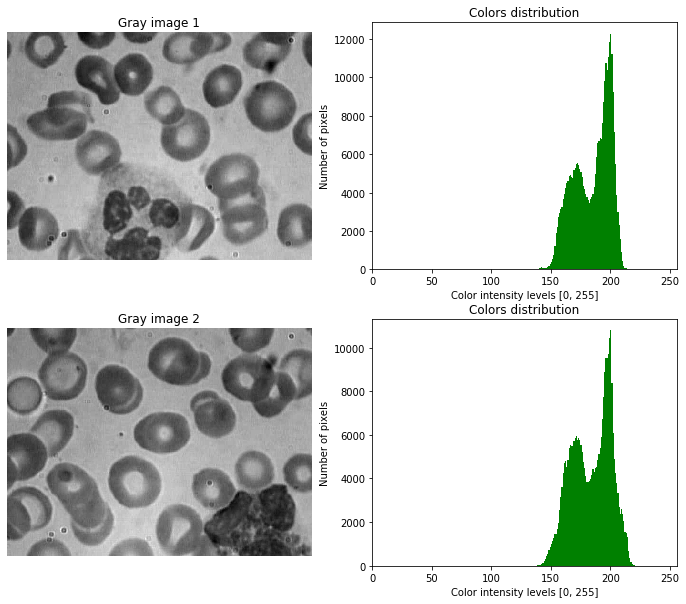

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
plot_image(gray_image1, "Gray image 1", plot_axis = ax1, show_figure = False)
plot_image_colors_histogram(gray_image1, plot_axis = ax2, show_figure = False)
plot_image(gray_image2, "Gray image 2", plot_axis = ax3, show_figure = False)
plot_image_colors_histogram(gray_image2, plot_axis = ax4, show_figure = False)
plt.show()

We can consider the discrete grayscale image {x} as a matrix of integer pixel intensities ranging from 0 to L-1 (usually 256).

1.) Find the probability of each pixel intensity

$$ p_{x}(i) = p_{x}(x=j) = \frac{n_{i}}{n}, i = 0, 1, ..., L-1 $$
 * $ n_{i} $ - the number of the pixels with intensity i
 * $ n $ - the total number of pixels in the image

2.) Find the cummulatitive probability - the probability that the pixel intensity is less than or equal to a given value
$$ cdf_{x}(i)=\sum_{j=0}^{i}p_{x}(x=j)$$

3.) Contrast stretching to the new range of value 

 $$ x_{i}=(x_{i}-{\text{Min}}){\frac {{\text{newMax}}-{\text{newMin}}}{{\text{Max}}-{\text{Min}}}}+{\text{newMin}} $$

4.) Remapping the image to the new values based on the lookup table with the new values

In [9]:
def normalize(image, new_min, new_max):
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) * (new_max - new_min)/(image_max - image_min) + new_min
    
def equalize_histogram(image):
    hist, bins = np.histogram(image1.flatten(), 256, [0,256])
    
    # [sum(h[:i+1]) for i in range(len(h))]
    cdf = np.cumsum(hist)
    
    # normalize cdf values between [0, 255]
    cdf_mask = np.ma.masked_equal(cdf, 0) # ignore zeroes
    cdf_mask = normalize(cdf_mask, 0, 255)
    normalized_cdf = np.ma.filled(cdf_mask, 0).astype('uint8')
    
    return normalized_cdf[image]

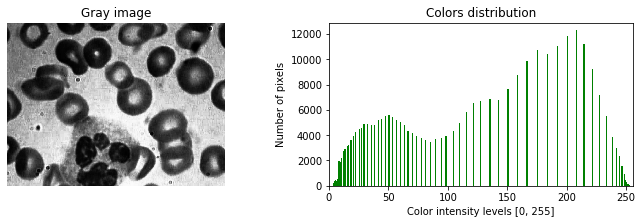

In [10]:
enhanced_image = equalize_histogram(gray_image1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
plot_image(enhanced_image, "Gray image", plot_axis = ax1, show_figure = False)
plot_image_colors_histogram(enhanced_image, plot_axis = ax2, show_figure = False)
plt.show()

Fortunately, we can use the OpenCV function: cv2.equalizeHist(img)

>Note:
>Histogram equalization is good when histogram of the image is confined to a particular region. But it is not always the case.

So it is better not to consider the global contrast of the image but try to process smaller blocks and histogram equalized them. The process is called adaptive histogram equalization - Contrast Limiting Adaptive Histogram Equalization (CLAHE). It is again implemented in OpenCV.

1.) The image is divided into small blocks or “tiles” (tileSize is 8x8 by default) and are histogram equalized.

2.) Contrast limiting is applied to avoid amplifying the noise in the small blocks. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. 

3.) Bilinear interpolation is applied after the equalization, to remove artifacts in tile borders.

We apply CLAHE to the RGB image (OpenCV BGR). In order to do that, we use LAB color space on the L (lightness/intensity value) preserving the color components.

> LAB:
> * L – Lightness (Intensity)
> * a – color component ranging from Green to Magenta
> * b – color component ranging from Blue to Yellow

In [11]:
def increase_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
    l2 = clahe.apply(l)

    lab = cv2.merge((l2,a,b))
    img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 
    
    return img2

### Edges and Gaussian Filter

Our main aim is to find the edges between cells in order to extract them. In images edges occur at boundaries between regions of different color, intensity or texture. A widely used approach is to define an edge as a location of rapid intensity variation.
A mathematical way to define the slope and direction of a surface is through its gradient:

$$ J(x) = ∇I(x)=( \frac{∂I}{∂x}, \frac{∂I}{∂y})(x)$$

* the magnitude is an indication of the slope or strength of the variation
$$ ||∇f(x)|| = \sqrt {(\frac{∂f}{dx})^{2}+(\frac{∂f}{∂y})^{2}} $$ 
* the orientation points in the direction of the most rapid increase in intensity (the steepest ascent)
$$ \theta = {tan{^{-1}}} \left[{\frac{∂f}{∂y}}/{\frac{∂f}{∂x}}\right] $$

<img src="https://image.slidesharecdn.com/finalminorprojectppt-140422115839-phpapp02/95/fuzzy-logic-based-edge-detection-16-638.jpg?cb=1398168182">

Unfortunately, taking image derivatives increases high frequencies and hence amplifies
noise, since the proportion of noise to signal is larger at high frequencies. It is therefore
prudent to smooth the image with a low-pass filter prior to computing the gradient. Because
we would like the response of our edge detector to be independent of orientation, a circularly symmetric smoothing filter is desirable, such as the Gaussian filter.

The Gaussian Filter is used to blur an image in order to remove noise. It involves determining the weighted average of the surrounding pixels and has a parameter sigma - the variation. The kernel represents a discrete approximation of a Gaussian distribution. While the Gaussian filter blurs the edges of an image (like the mean filter) it does a better job of preserving edges than a similarly sized mean filter.

### Image Segmentation

Now, as we have done some prepocessing, we can try to divide the image into segments in order to find the objects of interest - the separate cells.

In [12]:
def find_cell_edges(image, show_steps = True):
    image_with_increased_contrast = increase_contrast(image)
    if show_steps:
        plot_image(image_with_increased_contrast, "Image with increased contrast")
    
    gray_image = cv2.cvtColor(image_with_increased_contrast, cv2.COLOR_RGB2GRAY)
    if show_steps:
        plot_image(gray_image, "Grayscale image")
    
    equalized_image = cv2.equalizeHist(gray_image)
    if show_steps:
        plot_image(equalized_image, "Image with an equalized histogram")
    
    smoothen_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)
    if show_steps:
        plot_image(smoothen_image, "Applied Gaussian Blur")
    
    otsu_threshold, otsu_image = cv2.threshold(gray_image, 0, 255,
                                               cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    if show_steps:
        plot_image(otsu_image, "Applied Otsu thresholding")
    
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    image_closed_otsu = cv2.morphologyEx(otsu_image, cv2.MORPH_CLOSE, 
                                         structuring_element, iterations = 3)
    if show_steps:
        plot_image(image_closed_otsu, "Applied Closing by 3x3 ellipse = the erosion of the dilation")
    
    canny_image = cv2.Canny(image_closed_otsu, otsu_threshold, 0.5*otsu_threshold)
    if show_steps:
        plot_image(canny_image, "Find Canny edges")
    
    return canny_image

In [13]:
class Contour:
    
    def __init__(self, contour):
        self.contour = contour 
        
        area = cv2.contourArea(contour)
        (x, y), radius = cv2.minEnclosingCircle(contour)
        
        # the diameter of the circle whose area is same as the contour area
        equivalent_diameter = np.sqrt(4*area/np.pi)
        # enclosing circle
        enclosing_circle_center_x, enclosing_circle_center_y = (int(x), int(y))
        enclosing_circle_diameter = 2 * int(radius)
        
        self.contour_data = {
            "area": area,
            "equivalent_diameter": equivalent_diameter,
            "enclosing_circle_center_x": enclosing_circle_center_x,
            "enclosing_circle_center_y": enclosing_circle_center_y,
            "enclosing_circle_diameter": enclosing_circle_diameter}
        

In [14]:
def draw_contours_by_edges(image, 
                           image_edges,
                           show_figure = True,
                           plot_axis = None):
    contours_with_data = []
    _, contours, _ = cv2.findContours(image_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cv_contour in contours:
        contour = Contour(cv_contour)
        if (contour.contour_data["area"] > 0.1):    
            contours_with_data.append(contour)
            cv2.drawContours(image, contour.contour, -1, (0, 255, 0), 3)
            cv2.circle(image,
                       (contour.contour_data["enclosing_circle_center_x"], 
                        contour.contour_data["enclosing_circle_center_y"]), 
                       int(contour.contour_data["enclosing_circle_diameter"]/2),
                       (255, 0, 0), 2)

    plot_image(image, "Enclosing circles around possible cells", 
               show_figure = show_figure,
               plot_axis = plot_axis)
    
    return contours_with_data

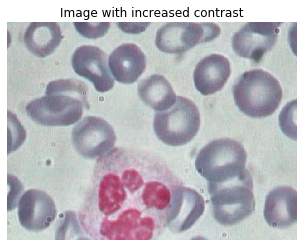

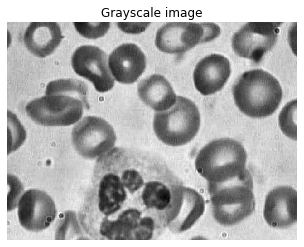

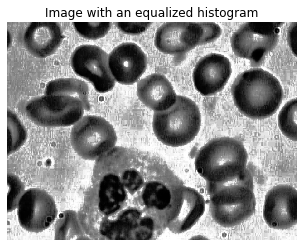

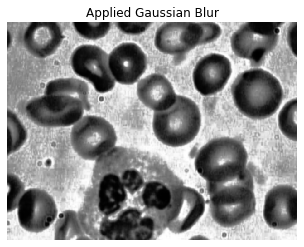

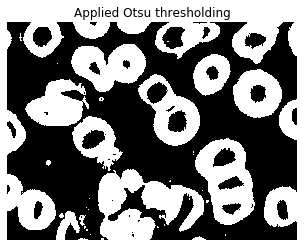

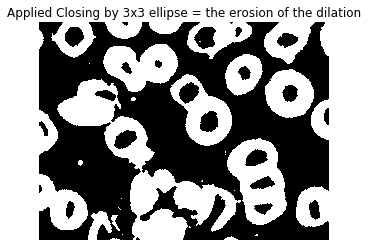

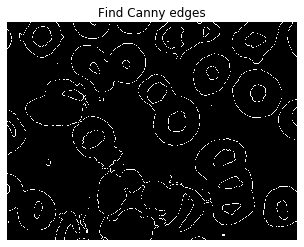

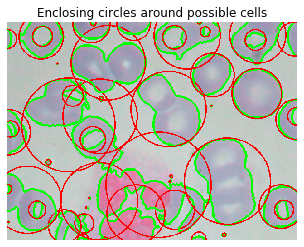

In [15]:
image_with_defined_edges_around_cells = find_cell_edges(image1)
image_contours = draw_contours_by_edges(image1, image_with_defined_edges_around_cells)

## Extract cell contour features

In [16]:
def write_properites(image_contours, csv_file_name):
    
    output_file = open(csv_file_name, "w")
    output_file.write(",".join(image_contours[0].contour_data.keys()) + "\n")

    for contour in image_contours:
        for value in contour.contour_data.values():
            output_file.write(str(value))
            output_file.write(",")
        output_file.write("\n")


In [17]:
write_properites(image_contours, "./data/contour_features.csv")

In [18]:
contours = pd.read_csv("./data/contour_features.csv", index_col = False)
contours.head()

,area,equivalent_diameter,enclosing_circle_center_x,enclosing_circle_center_y,enclosing_circle_diameter
0,1.0,1.128379,167,478,24
1,7.0,2.985411,217,478,10
2,6.0,2.763953,423,478,32
3,5.5,2.646284,479,468,8
4,4.0,2.256758,3,440,2


## Visual tests with another different dataset

Now, let's try with some different dataset and see whether the segmentation is at least a little bit robust and can extract cells from other images.
The other dataset is actually an online atlas - Hematology Atlas with a few images of blood smears in case of leukemias. 

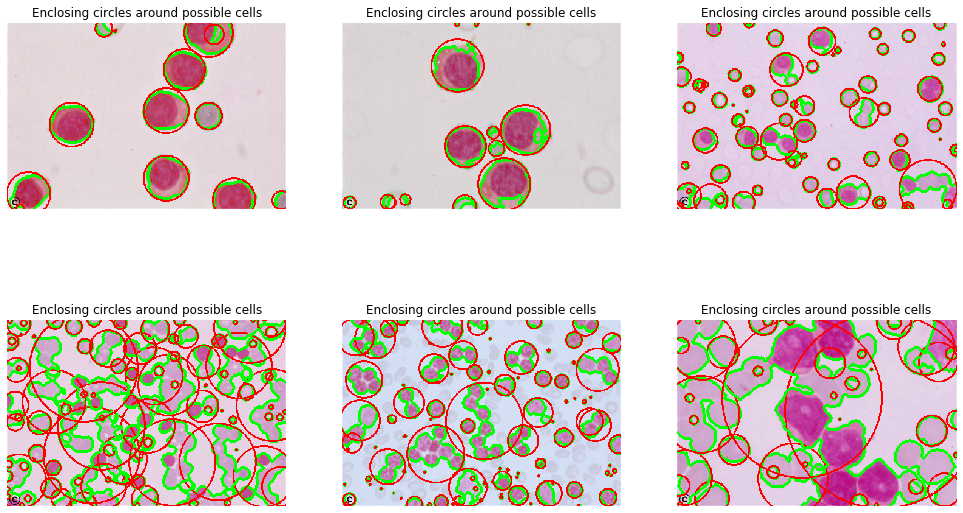

In [19]:
URL2 = "http://www.hematologyatlas.com/leukemias/"
PATH = "./data/hematology_atlas/"
_, axes_tuples = plt.subplots(2, 3, figsize = (17, 10))
axes = [ax for t in axes_tuples for ax in t] 
a = 45
b = a + len(axes)+1
for i in range(a, b):
    test_image = read_image_by_url(URL2 + str(i) + ".jpg")
    #plot_image(test_image, "Test Blood Smear Image " + str(i), 
    #           plot_axis = axes[i-1], show_figure = False)
    test_image_edges = find_cell_edges(test_image, show_steps = False)
    image_contours = draw_contours_by_edges(test_image, test_image_edges,
                                            plot_axis = axes[i-a-1],
                                            show_figure = False)
plt.show()  

Unfortunately, as in the base dataset, it can be clearly seen, the image segmentation technique should still be updated in order to extract more correctly tightly connected cells as it consider them as one whole blob. Here it is even more clear with different dimensions of the blood smear.

## Conclusion

Image segmentation and cells features extraction is important process toward further investigation of properties of cells and creating machine learning models. In this notebook, we look through some of the basic steps for extracting of cells and their feautures from different images with blood smears ...............

## Bibliography

1. OpenCV tutorials and documentation: 
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html

2. Sreenivas Bhattiprolu, Python for Microscopists: https://www.youtube.com/channel/UC34rW-HtPJulxr5wp2Xa04w

3. Abdullah Elen, Muhammed Kamil Turan, A new approach for fully automated segmentation of peripheral blood smears, https://www.academia.edu/35289070/A_new_approach_for_fully_automated_segmentation_of_peripheral_blood_smears?email_work_card=reading-history

4. Classification of Leukemia Detection in Human Blood Sample Based on Microscopic Images,  Ei Ei Chaw, Ohnmar Win https://www.academia.edu/resource/work/39747420/Classification_of_Leukemia_Detection_in_Human_Blood_Sample_Based_on_Microscopic_Images?email_work_card=reading-history

5. Computer Vision, Algorithms and Applications, Richard Szeliski - https://link.springer.com/book/10.1007/978-1-84882-935-0

